## Курсовой проект

### -- Автор: Шенк Евгений Станиславович

In [1]:
import numpy as np
import pandas as pd
import lightgbm as lgb
import xgboost as xgb
import catboost as cb
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Tuple, Optional
import os
import time
import json

from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold, train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import OrdinalEncoder

from sklearn.inspection import permutation_importance
from scipy.stats import gmean

from src.utils import show_feature_importances, do_train_test_split, make_cross_validation, create_numerical_aggs

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
pd.options.display.max_columns = 400

In [3]:
def calc_val_proba_results(estimator: object):
    train_score = roc_auc_score(y_train, estimator.predict_proba(x_train)[:,1])
    print(f'Train roc_auc_score: {train_score}')
    valid_score = roc_auc_score(y_valid, estimator.predict_proba(x_valid)[:,1])
    print(f'Valid roc_auc_score: {valid_score}')
    test_score = roc_auc_score(y_test, estimator.predict_proba(x_test)[:,1])
    print(f'Test roc_auc_score:  {test_score}')
    return(train_score, valid_score, test_score)

### Загрузка датасета

In [4]:
data_path='./data/'

train_data = pd.read_csv(os.path.join(data_path, "train.csv"))
test_data = pd.read_csv(os.path.join(data_path, "test.csv"))
payments_data = pd.read_csv(os.path.join(data_path, "payments.csv"))
client_profile_data = pd.read_csv(os.path.join(data_path, "client_profile.csv"))
bki_data = pd.read_csv(os.path.join(data_path, "bki.csv"))
applications_history_data = pd.read_csv(os.path.join(data_path, "applications_history.csv"))

print("train_data.shape = {} rows, {} cols".format(*train_data.shape))
print("test_data.shape = {} rows, {} cols".format(*test_data.shape))
print("payments_data.shape = {} rows, {} cols".format(*payments_data.shape))
print("client_profile_data.shape = {} rows, {} cols".format(*client_profile_data.shape))
print("bki_data.shape = {} rows, {} cols".format(*bki_data.shape))
print("applications_history_data.shape = {} rows, {} cols".format(*applications_history_data.shape))

train_data.shape = 110093 rows, 3 cols
test_data.shape = 165141 rows, 2 cols
payments_data.shape = 1023932 rows, 8 cols
client_profile_data.shape = 250000 rows, 24 cols
bki_data.shape = 945234 rows, 17 cols
applications_history_data.shape = 1670214 rows, 26 cols


In [5]:
target = ['TARGET']

In [6]:
train_data.head(3)

,APPLICATION_NUMBER,TARGET,NAME_CONTRACT_TYPE
0,123687442,0,Cash
1,123597908,1,Cash
2,123526683,0,Cash


In [7]:
test_data.head(3)

,APPLICATION_NUMBER,NAME_CONTRACT_TYPE
0,123724268,Cash
1,123456549,Cash
2,123428178,Credit Card


In [8]:
client_profile_data.head(3)

,APPLICATION_NUMBER,GENDER,CHILDRENS,TOTAL_SALARY,AMOUNT_CREDIT,AMOUNT_ANNUITY,EDUCATION_LEVEL,FAMILY_STATUS,REGION_POPULATION,AGE,DAYS_ON_LAST_JOB,OWN_CAR_AGE,FLAG_PHONE,FLAG_EMAIL,FAMILY_SIZE,EXTERNAL_SCORING_RATING_1,EXTERNAL_SCORING_RATING_2,EXTERNAL_SCORING_RATING_3,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,123666076,F,0,157500.0,270000.0,13500.0,Incomplete higher,Civil marriage,0.008068,8560,1549,NaN,1,0,2.0,0.329471,0.236315,0.678568,0.0,0.0,0.0,0.0,1.0,2.0
1,123423688,F,0,270000.0,536917.5,28467.0,Secondary / secondary special,Married,0.020246,23187,365243,NaN,0,0,2.0,NaN,0.442295,0.802745,0.0,0.0,0.0,0.0,1.0,1.0
2,123501780,M,1,427500.0,239850.0,23850.0,Incomplete higher,Married,0.072508,14387,326,18.0,0,0,3.0,0.409017,0.738159,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
payments_data.head(3)

,PREV_APPLICATION_NUMBER,APPLICATION_NUMBER,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,49011181,123664960,1.0,5,1002.0,1015.0,12156.615,12156.615
1,48683432,123497205,1.0,13,442.0,432.0,18392.535,10047.645
2,48652024,123749925,1.0,10,8.0,23.0,5499.945,5499.945


In [10]:
bki_data.head(3)

,APPLICATION_NUMBER,BUREAU_ID,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,123538884,5223613,Active,currency 1,718.0,0,377.0,NaN,19386.81,0,675000.00,320265.495,0.0,0.0,Consumer credit,39.0,NaN
1,123436670,6207544,Closed,currency 1,696.0,0,511.0,511.0,0.00,0,93111.66,0.000,0.0,0.0,Consumer credit,505.0,NaN
2,123589020,6326395,Closed,currency 1,165.0,0,149.0,160.0,NaN,0,36000.00,0.000,0.0,0.0,Consumer credit,150.0,0.0


In [11]:
applications_history_data.head(3)

,PREV_APPLICATION_NUMBER,APPLICATION_NUMBER,NAME_CONTRACT_TYPE,AMOUNT_ANNUITY,AMT_APPLICATION,AMOUNT_CREDIT,AMOUNT_PAYMENT,AMOUNT_GOODS_PAYMENT,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,SELLERPLACE_AREA,CNT_PAYMENT,NAME_YIELD_GROUP,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,49298709,123595216,NaN,1730.430,17145.0,17145.0,0.0,17145.0,Approved,73,Cash through the bank,XAP,NaN,Repeater,Mobile,POS,XNA,35,12.0,middle,365243.0,42.0,300.0,42.0,37.0,0.0
1,50070639,123431468,Cash,25188.615,607500.0,679671.0,NaN,607500.0,Approved,164,XNA,XAP,Unaccompanied,Repeater,XNA,Cash,x-sell,-1,36.0,low_action,365243.0,134.0,916.0,365243.0,365243.0,1.0
2,49791680,123445379,Cash,15060.735,112500.0,136444.5,NaN,112500.0,Approved,301,Cash through the bank,XAP,"Spouse, partner",Repeater,XNA,Cash,x-sell,-1,12.0,high,365243.0,271.0,59.0,365243.0,365243.0,1.0


<h2>
<div class="alert-success">
<font size="6" color='blue'>
Dataset
</font></div></h2>

In [12]:
def data_preparation(data: pd.DataFrame, cats_to_dummies: list):
    """
        Подготовака данных.

        Parameters
    ----------
    data: pandas.core.frame.DataFrame
        Выборка для построения агрегаций.

    cats_to_dummies: list
        Список названий категориальных признаков
    """

    # Убираем плохие значения
    data = data.replace(np.inf, np.nan)
    data = data.replace(-np.inf, np.nan)

    # Энкодинг категориальных переменных в дамми
    data = pd.get_dummies(data, columns=cats_to_dummies, dummy_na=True)

    return data


def client_profile_prep(data: pd.DataFrame, client_profile_data_df: pd.DataFrame):
    """
        Добавление, обработка и генерация признаков из клиентского профиля (client_profile).
    """
    data = data.merge(client_profile_data_df, how='left', on='APPLICATION_NUMBER')

    # Очистка и преобразование
    data['DAYS_ON_LAST_JOB'][data['DAYS_ON_LAST_JOB'] == 365243] = np.nan
    data = data.drop('CHILDRENS', axis=1)
    data['AGE'] = (data['AGE'] / 365) // 1

    # Генерация фичей
    data['AA_AC_ratio'] = data['AMOUNT_ANNUITY'] / data['AMOUNT_CREDIT']
    data['TS_AA_ratio'] = data['TOTAL_SALARY'] / data['AMOUNT_ANNUITY']
    data['TS_AC_ratio'] = data['TOTAL_SALARY'] / data['AMOUNT_CREDIT']

    data['AGE_JOB_ratio'] = data['AGE'] / data['DAYS_ON_LAST_JOB']
    data['AGE_CAR_ratio'] = data['AGE'] / data['OWN_CAR_AGE']
    data['CAR_JOB_ratio'] = data['OWN_CAR_AGE'] / data['DAYS_ON_LAST_JOB']

    data['AA_AGE_ratio'] = data['AMOUNT_ANNUITY'] / data['AGE']
    data['TS_AGE_ratio'] = data['TOTAL_SALARY'] / data['AGE']
    data['AC_AGE_ratio'] = data['AMOUNT_CREDIT'] / data['AGE']
    data['AA_JOB_ratio'] = data['AMOUNT_ANNUITY'] / data['DAYS_ON_LAST_JOB']
    data['TS_JOB_ratio'] = data['TOTAL_SALARY'] / data['DAYS_ON_LAST_JOB']
    data['AC_JOB_ratio'] = data['AMOUNT_CREDIT'] / data['DAYS_ON_LAST_JOB']
    data['AA_CAR_ratio'] = data['AMOUNT_ANNUITY'] / data['OWN_CAR_AGE']
    data['TS_CAR_ratio'] = data['TOTAL_SALARY'] / data['OWN_CAR_AGE']
    data['AC_CAR_ratio'] = data['AMOUNT_CREDIT'] / data['OWN_CAR_AGE']

    for function_name in ['min', 'max', 'mean', 'nanmedian', 'var']:
        feature_name = f'EXTERNAL_SCORING_RATING_{function_name}'
        data[feature_name] = eval(f'np.{function_name}')(
            data[['EXTERNAL_SCORING_RATING_1', 'EXTERNAL_SCORING_RATING_2', 'EXTERNAL_SCORING_RATING_3']],
            axis=1
        )

    data['AA_AC_ratio_ESR_1'] = data['AA_AC_ratio'] * data['EXTERNAL_SCORING_RATING_1']
    data['AA_AC_ratio_ESR_2'] = data['AA_AC_ratio'] * data['EXTERNAL_SCORING_RATING_2']
    data['AA_AC_ratio_ESR_3'] = data['AA_AC_ratio'] * data['EXTERNAL_SCORING_RATING_3']
    data['AA_AC_ratio_ESR_mean'] = data['AA_AC_ratio'] * data['EXTERNAL_SCORING_RATING_mean']

    data['ESR_1_AA'] = data['AMOUNT_ANNUITY'] * data['EXTERNAL_SCORING_RATING_1']
    data['ESR_2_AA'] = data['AMOUNT_ANNUITY'] * data['EXTERNAL_SCORING_RATING_2']
    data['ESR_3_AA'] = data['AMOUNT_ANNUITY'] * data['EXTERNAL_SCORING_RATING_3']
    data['ESR_1_AC'] = data['AMOUNT_CREDIT'] * data['EXTERNAL_SCORING_RATING_1']
    data['ESR_2_AC'] = data['AMOUNT_CREDIT'] * data['EXTERNAL_SCORING_RATING_2']
    data['ESR_3_AC'] = data['AMOUNT_CREDIT'] * data['EXTERNAL_SCORING_RATING_3']
    data['ESR_1_AGE'] = data['AGE'] * data['EXTERNAL_SCORING_RATING_1']
    data['ESR_2_AGE'] = data['AGE'] * data['EXTERNAL_SCORING_RATING_2']
    data['ESR_3_AGE'] = data['AGE'] * data['EXTERNAL_SCORING_RATING_3']
    data['ESR_1_JOB'] = data['DAYS_ON_LAST_JOB'] * data['EXTERNAL_SCORING_RATING_1']
    data['ESR_2_JOB'] = data['DAYS_ON_LAST_JOB'] * data['EXTERNAL_SCORING_RATING_2']
    data['ESR_3_JOB'] = data['DAYS_ON_LAST_JOB'] * data['EXTERNAL_SCORING_RATING_3']
    data['ESR_1_2_3'] = data['EXTERNAL_SCORING_RATING_1'] * data[
        'EXTERNAL_SCORING_RATING_2'] * data['EXTERNAL_SCORING_RATING_3']
    data['ESR_1_2_3_sum'] = data['EXTERNAL_SCORING_RATING_1'] + data[
        'EXTERNAL_SCORING_RATING_2'] + data['EXTERNAL_SCORING_RATING_3']

    return data

def payments_data_prep(data: pd.DataFrame, payments_data_df: pd.DataFrame):
    """
        Добавление, обработка и генерация признаков из истории платежей клиента (payments).
    """

    aggs = {
        'NUM_INSTALMENT_VERSION': [np.min, np.max, np.mean, np.std],
        'NUM_INSTALMENT_NUMBER': [np.min, np.max, np.mean, np.std],
        'AMT_INSTALMENT': [np.min, np.max, np.mean, np.sum, np.std],
        'AMT_PAYMENT': [np.min, np.max, np.mean, np.sum, np.std],
        "APPLICATION_NUMBER": [np.min, np.max, np.mean, np.std]
    }
    feat_list = ["APPLICATION_NUMBER"]

    for feat in feat_list:
        stats = create_numerical_aggs(
            payments_data_df, groupby_id=feat, aggs=aggs, prefix="PAYMENT_", suffix=f""
        )

        data = data.merge(stats, how='left', on='APPLICATION_NUMBER')

    return data

def bki_data_prep(data: pd.DataFrame, bki_data_df: pd.DataFrame):
    """
        Добавление, обработка и генерация признаков из данных о предыдущих кредитах клиента (bki).
    """

    aggs = {
        'DAYS_CREDIT': [np.min, np.max, np.mean, np.sum, np.std],
        'CREDIT_DAY_OVERDUE': [np.min, np.max, np.mean, np.sum, np.std],
        'DAYS_CREDIT_ENDDATE': [np.min, np.max, np.mean, np.std],
        'AMT_CREDIT_MAX_OVERDUE': [np.min, np.max, np.mean, np.std],
        'CNT_CREDIT_PROLONG': [np.min, np.max, np.mean, np.sum, np.std],
        "AMT_CREDIT_SUM": [np.min, np.max, np.mean, np.sum, np.std],
        "AMT_CREDIT_SUM_DEBT": [np.min, np.max, np.mean, np.sum, np.std],
        "AMT_CREDIT_SUM_LIMIT": [np.min, np.max, np.mean, np.std],
        "AMT_CREDIT_SUM_OVERDUE": [np.min, np.max, np.mean, np.sum, np.std],
        "DAYS_CREDIT_UPDATE": [np.min, np.max, np.mean, np.std],
        "AMT_ANNUITY": [np.min, np.max, np.mean, np.std],
    }
    feat_list = ["APPLICATION_NUMBER"]

    for feat in feat_list:
        stats = create_numerical_aggs(
            bki_data_df, groupby_id=feat, aggs=aggs, prefix="BKI_", suffix=f""
        )

        data = data.merge(stats, how='left', on='APPLICATION_NUMBER')

    data['DEBT_CREDIT_ratio'] = data['BKI_AMT_CREDIT_SUM_DEBT_SUM'] / data[
        'BKI_AMT_CREDIT_SUM_SUM']

    return data

def applications_history_data_prep(data: pd.DataFrame, applications_history_data_df: pd.DataFrame):
    """
        Добавление, обработка и генерация признаков из истории предыдущих заявок клиента (applications_history).
    """

    aggs = {
        'AMOUNT_ANNUITY': [np.min, np.max, np.mean, np.sum, np.std],
        'AMT_APPLICATION': [np.min, np.max, np.mean, np.sum, np.std],
        'AMOUNT_CREDIT': [np.min, np.max, np.mean, np.sum, np.std],
        'AMOUNT_PAYMENT': [np.min, np.max, np.mean, np.sum, np.std],
        'AMOUNT_GOODS_PAYMENT': [np.min, np.max, np.mean, np.sum, np.std],
        "DAYS_DECISION": [np.min, np.max, np.mean, np.std],
        "CNT_PAYMENT": [np.min, np.max, np.mean, np.sum, np.std],
        "DAYS_FIRST_DRAWING": [np.min, np.max, np.mean, np.std],
        "DAYS_LAST_DUE_1ST_VERSION": [np.min, np.max, np.mean, np.std],
        "DAYS_LAST_DUE": [np.min, np.max, np.mean, np.std],
        "DAYS_TERMINATION": [np.min, np.max, np.mean, np.std],
    }
    feat_list = ["APPLICATION_NUMBER"]

    for feat in feat_list:
        stats = create_numerical_aggs(
            applications_history_data_df, groupby_id=feat, aggs=aggs, prefix="HISTORY_", suffix=f""
        )

        data = data.merge(stats, how='left', on='APPLICATION_NUMBER')

    return data

In [13]:
train_data = client_profile_prep(train_data, client_profile_data)
train_data = payments_data_prep(train_data, payments_data)
train_data = bki_data_prep(train_data, bki_data)
train_data = applications_history_data_prep(train_data, applications_history_data)
train_data = data_preparation(train_data, cats_to_dummies=['NAME_CONTRACT_TYPE', 'GENDER', 'EDUCATION_LEVEL', 'FAMILY_STATUS'])
train_data.shape

(110093, 202)

In [14]:
train_data.head(2)

,APPLICATION_NUMBER,TARGET,TOTAL_SALARY,AMOUNT_CREDIT,AMOUNT_ANNUITY,REGION_POPULATION,AGE,DAYS_ON_LAST_JOB,OWN_CAR_AGE,FLAG_PHONE,FLAG_EMAIL,FAMILY_SIZE,EXTERNAL_SCORING_RATING_1,EXTERNAL_SCORING_RATING_2,EXTERNAL_SCORING_RATING_3,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,AA_AC_ratio,TS_AA_ratio,TS_AC_ratio,AGE_JOB_ratio,AGE_CAR_ratio,CAR_JOB_ratio,AA_AGE_ratio,TS_AGE_ratio,AC_AGE_ratio,AA_JOB_ratio,TS_JOB_ratio,AC_JOB_ratio,AA_CAR_ratio,TS_CAR_ratio,AC_CAR_ratio,EXTERNAL_SCORING_RATING_min,EXTERNAL_SCORING_RATING_max,EXTERNAL_SCORING_RATING_mean,EXTERNAL_SCORING_RATING_nanmedian,EXTERNAL_SCORING_RATING_var,AA_AC_ratio_ESR_1,AA_AC_ratio_ESR_2,AA_AC_ratio_ESR_3,AA_AC_ratio_ESR_mean,ESR_1_AA,ESR_2_AA,ESR_3_AA,ESR_1_AC,ESR_2_AC,ESR_3_AC,ESR_1_AGE,ESR_2_AGE,ESR_3_AGE,ESR_1_JOB,ESR_2_JOB,ESR_3_JOB,ESR_1_2_3,ESR_1_2_3_sum,PAYMENT_NUM_INSTALMENT_VERSION_AMIN,PAYMENT_NUM_INSTALMENT_VERSION_AMAX,PAYMENT_NUM_INSTALMENT_VERSION_MEAN,PAYMENT_NUM_INSTALMENT_VERSION_STD,PAYMENT_NUM_INSTALMENT_NUMBER_AMIN,PAYMENT_NUM_INSTALMENT_NUMBER_AMAX,PAYMENT_NUM_INSTALMENT_NUMBER_MEAN,PAYMENT_NUM_INSTALMENT_NUMBER_STD,PAYMENT_AMT_INSTALMENT_AMIN,PAYMENT_AMT_INSTALMENT_AMAX,PAYMENT_AMT_INSTALMENT_MEAN,PAYMENT_AMT_INSTALMENT_SUM,PAYMENT_AMT_INSTALMENT_STD,PAYMENT_AMT_PAYMENT_AMIN,PAYMENT_AMT_PAYMENT_AMAX,PAYMENT_AMT_PAYMENT_MEAN,PAYMENT_AMT_PAYMENT_SUM,PAYMENT_AMT_PAYMENT_STD,PAYMENT_APPLICATION_NUMBER_AMIN,PAYMENT_APPLICATION_NUMBER_AMAX,PAYMENT_APPLICATION_NUMBER_MEAN,PAYMENT_APPLICATION_NUMBER_STD,BKI_DAYS_CREDIT_AMIN,BKI_DAYS_CREDIT_AMAX,BKI_DAYS_CREDIT_MEAN,BKI_DAYS_CREDIT_SUM,BKI_DAYS_CREDIT_STD,BKI_CREDIT_DAY_OVERDUE_AMIN,BKI_CREDIT_DAY_OVERDUE_AMAX,BKI_CREDIT_DAY_OVERDUE_MEAN,BKI_CREDIT_DAY_OVERDUE_SUM,BKI_CREDIT_DAY_OVERDUE_STD,BKI_DAYS_CREDIT_ENDDATE_AMIN,BKI_DAYS_CREDIT_ENDDATE_AMAX,BKI_DAYS_CREDIT_ENDDATE_MEAN,BKI_DAYS_CREDIT_ENDDATE_STD,BKI_AMT_CREDIT_MAX_OVERDUE_AMIN,BKI_AMT_CREDIT_MAX_OVERDUE_AMAX,BKI_AMT_CREDIT_MAX_OVERDUE_MEAN,BKI_AMT_CREDIT_MAX_OVERDUE_STD,BKI_CNT_CREDIT_PROLONG_AMIN,BKI_CNT_CREDIT_PROLONG_AMAX,BKI_CNT_CREDIT_PROLONG_MEAN,BKI_CNT_CREDIT_PROLONG_SUM,BKI_CNT_CREDIT_PROLONG_STD,BKI_AMT_CREDIT_SUM_AMIN,BKI_AMT_CREDIT_SUM_AMAX,BKI_AMT_CREDIT_SUM_MEAN,BKI_AMT_CREDIT_SUM_SUM,BKI_AMT_CREDIT_SUM_STD,BKI_AMT_CREDIT_SUM_DEBT_AMIN,BKI_AMT_CREDIT_SUM_DEBT_AMAX,BKI_AMT_CREDIT_SUM_DEBT_MEAN,BKI_AMT_CREDIT_SUM_DEBT_SUM,BKI_AMT_CREDIT_SUM_DEBT_STD,BKI_AMT_CREDIT_SUM_LIMIT_AMIN,BKI_AMT_CREDIT_SUM_LIMIT_AMAX,BKI_AMT_CREDIT_SUM_LIMIT_MEAN,BKI_AMT_CREDIT_SUM_LIMIT_STD,BKI_AMT_CREDIT_SUM_OVERDUE_AMIN,BKI_AMT_CREDIT_SUM_OVERDUE_AMAX,BKI_AMT_CREDIT_SUM_OVERDUE_MEAN,BKI_AMT_CREDIT_SUM_OVERDUE_SUM,BKI_AMT_CREDIT_SUM_OVERDUE_STD,BKI_DAYS_CREDIT_UPDATE_AMIN,BKI_DAYS_CREDIT_UPDATE_AMAX,BKI_DAYS_CREDIT_UPDATE_MEAN,BKI_DAYS_CREDIT_UPDATE_STD,BKI_AMT_ANNUITY_AMIN,BKI_AMT_ANNUITY_AMAX,BKI_AMT_ANNUITY_MEAN,BKI_AMT_ANNUITY_STD,DEBT_CREDIT_ratio,HISTORY_AMOUNT_ANNUITY_AMIN,HISTORY_AMOUNT_ANNUITY_AMAX,HISTORY_AMOUNT_ANNUITY_MEAN,HISTORY_AMOUNT_ANNUITY_SUM,HISTORY_AMOUNT_ANNUITY_STD,HISTORY_AMT_APPLICATION_AMIN,HISTORY_AMT_APPLICATION_AMAX,HISTORY_AMT_APPLICATION_MEAN,HISTORY_AMT_APPLICATION_SUM,HISTORY_AMT_APPLICATION_STD,HISTORY_AMOUNT_CREDIT_AMIN,HISTORY_AMOUNT_CREDIT_AMAX,HISTORY_AMOUNT_CREDIT_MEAN,HISTORY_AMOUNT_CREDIT_SUM,HISTORY_AMOUNT_CREDIT_STD,HISTORY_AMOUNT_PAYMENT_AMIN,HISTORY_AMOUNT_PAYMENT_AMAX,HISTORY_AMOUNT_PAYMENT_MEAN,HISTORY_AMOUNT_PAYMENT_SUM,HISTORY_AMOUNT_PAYMENT_STD,HISTORY_AMOUNT_GOODS_PAYMENT_AMIN,HISTORY_AMOUNT_GOODS_PAYMENT_AMAX,HISTORY_AMOUNT_GOODS_PAYMENT_MEAN,HISTORY_AMOUNT_GOODS_PAYMENT_SUM,HISTORY_AMOUNT_GOODS_PAYMENT_STD,HISTORY_DAYS_DECISION_AMIN,HISTORY_DAYS_DECISION_AMAX,HISTORY_DAYS_DECISION_MEAN,HISTORY_DAYS_DECISION_STD,HISTORY_CNT_PAYMENT_AMIN,HISTORY_CNT_PAYMENT_AMAX,HISTORY_CNT_PAYMENT_MEAN,HISTORY_CNT_PAYMENT_SUM,HISTORY_CNT_PAYMENT_STD,HISTORY_DAYS_FIRST_DRAWING_AMIN,HISTORY_DAYS_FIRST_DRAWING_AMAX

In [15]:
numerical_features = train_data.drop(['APPLICATION_NUMBER', 'TARGET'], axis=1).columns

In [16]:
params = {
    "eval_metric": "auc",
    "verbose": 250,
    "early_stopping_rounds": 100,
}

<h2>
<div class="alert-info">
<font size="6" color='red'>
Валидация
</font></div></h2>

In [17]:
x_train, x_valid, x_test, y_train, y_valid, y_test = do_train_test_split(train_data, target,
                                                                         numerical_features,
                                                                         random_state=526354,
                                                                         train_size=0.8, valid_size=0.8)

x_train.shape = 88074 rows, 200 cols
x_valid.shape = 17615 rows, 200 cols
x_test.shape = 4404 rows, 200 cols


In [18]:
x_train_for_cv = train_data[numerical_features].reset_index(drop=True)
y_train_for_cv = train_data['TARGET'].reset_index(drop=True)

In [19]:
model_0 = None
model_0 = lgb.LGBMClassifier(n_estimators=10000, learning_rate=0.02, num_leaves=21, max_depth=-1,
                                 reg_alpha=1.0, reg_lambda=25, min_child_samples=250, min_child_weight=1,
                                 colsample_bytree=0.25, subsample=0.95,
                                 boosting_type='gbdt',
                                 seed=2177)

model_lgb_0 = None
model_lgb_0 = lgb.LGBMClassifier(n_estimators=10000, learning_rate=0.02, num_leaves=21, max_depth=-1,
                                 reg_alpha=1.0, reg_lambda=25, min_child_samples=250, min_child_weight=1,
                                 colsample_bytree=0.25, subsample=0.95,
                                 boosting_type='gbdt',
                                 seed=2177)

In [20]:
model_0.fit(x_train, y_train,
            eval_set=(x_valid, y_valid),
           **params)

Training until validation scores don't improve for 100 rounds
[250]	valid_0's auc: 0.733004	valid_0's binary_logloss: 0.254355
[500]	valid_0's auc: 0.735559	valid_0's binary_logloss: 0.25365
Early stopping, best iteration is:
[635]	valid_0's auc: 0.736379	valid_0's binary_logloss: 0.253533


LGBMClassifier(colsample_bytree=0.25, learning_rate=0.02, min_child_samples=250,
               min_child_weight=1, n_estimators=10000, num_leaves=21,
               reg_alpha=1.0, reg_lambda=25, seed=2177, subsample=0.95)

In [21]:
cv_strategy = StratifiedKFold(n_splits=7, random_state=6482597, shuffle=True)

estimators, oof_score, fold_train_scores, fold_valid_scores, oof_predictions = make_cross_validation(
    x_train_for_cv, y_train_for_cv, model_lgb_0, params, metric=roc_auc_score, cv_strategy=cv_strategy
)

Training until validation scores don't improve for 100 rounds
[250]	valid_0's auc: 0.724582	valid_0's binary_logloss: 0.254203
[500]	valid_0's auc: 0.725994	valid_0's binary_logloss: 0.253461
Early stopping, best iteration is:
[527]	valid_0's auc: 0.726193	valid_0's binary_logloss: 0.253373
Fold: 1, train-observations = 94365, valid-observations = 15728
train-score = 0.7867, valid-score = 0.7262
Training until validation scores don't improve for 100 rounds
[250]	valid_0's auc: 0.726522	valid_0's binary_logloss: 0.253152
[500]	valid_0's auc: 0.728655	valid_0's binary_logloss: 0.252278
Early stopping, best iteration is:
[522]	valid_0's auc: 0.728958	valid_0's binary_logloss: 0.252218
Fold: 2, train-observations = 94365, valid-observations = 15728
train-score = 0.7866, valid-score = 0.729
Training until validation scores don't improve for 100 rounds
[250]	valid_0's auc: 0.720631	valid_0's binary_logloss: 0.255034
[500]	valid_0's auc: 0.724167	valid_0's binary_logloss: 0.25421
Early stoppi

In [22]:
oof_score = roc_auc_score(y_train_for_cv, oof_predictions)
oof_score # 731867

0.7281721507699466

<h2>
<div class="alert-success">
<font size="6" color='blue'>
Permutation importance
</font></div></h2>

In [23]:
%%time
importance_0 = permutation_importance(
    model_0, x_valid, y_valid, scoring="roc_auc", n_jobs=-1, random_state=2468579)

Wall time: 5min 30s


In [24]:
importance_scores = pd.DataFrame({
    "features": x_valid.columns,
    "importance-mean": importance_0.importances_mean,
    "importance-std": importance_0.importances_std,
})
importance_scores = importance_scores.sort_values(
    by="importance-mean", ascending=False
)
importance_scores = importance_scores.reset_index(drop=True)
decrease_scores = importance_scores[importance_scores["importance-mean"]<=0]
decrease_scores = decrease_scores.reset_index(drop=True)

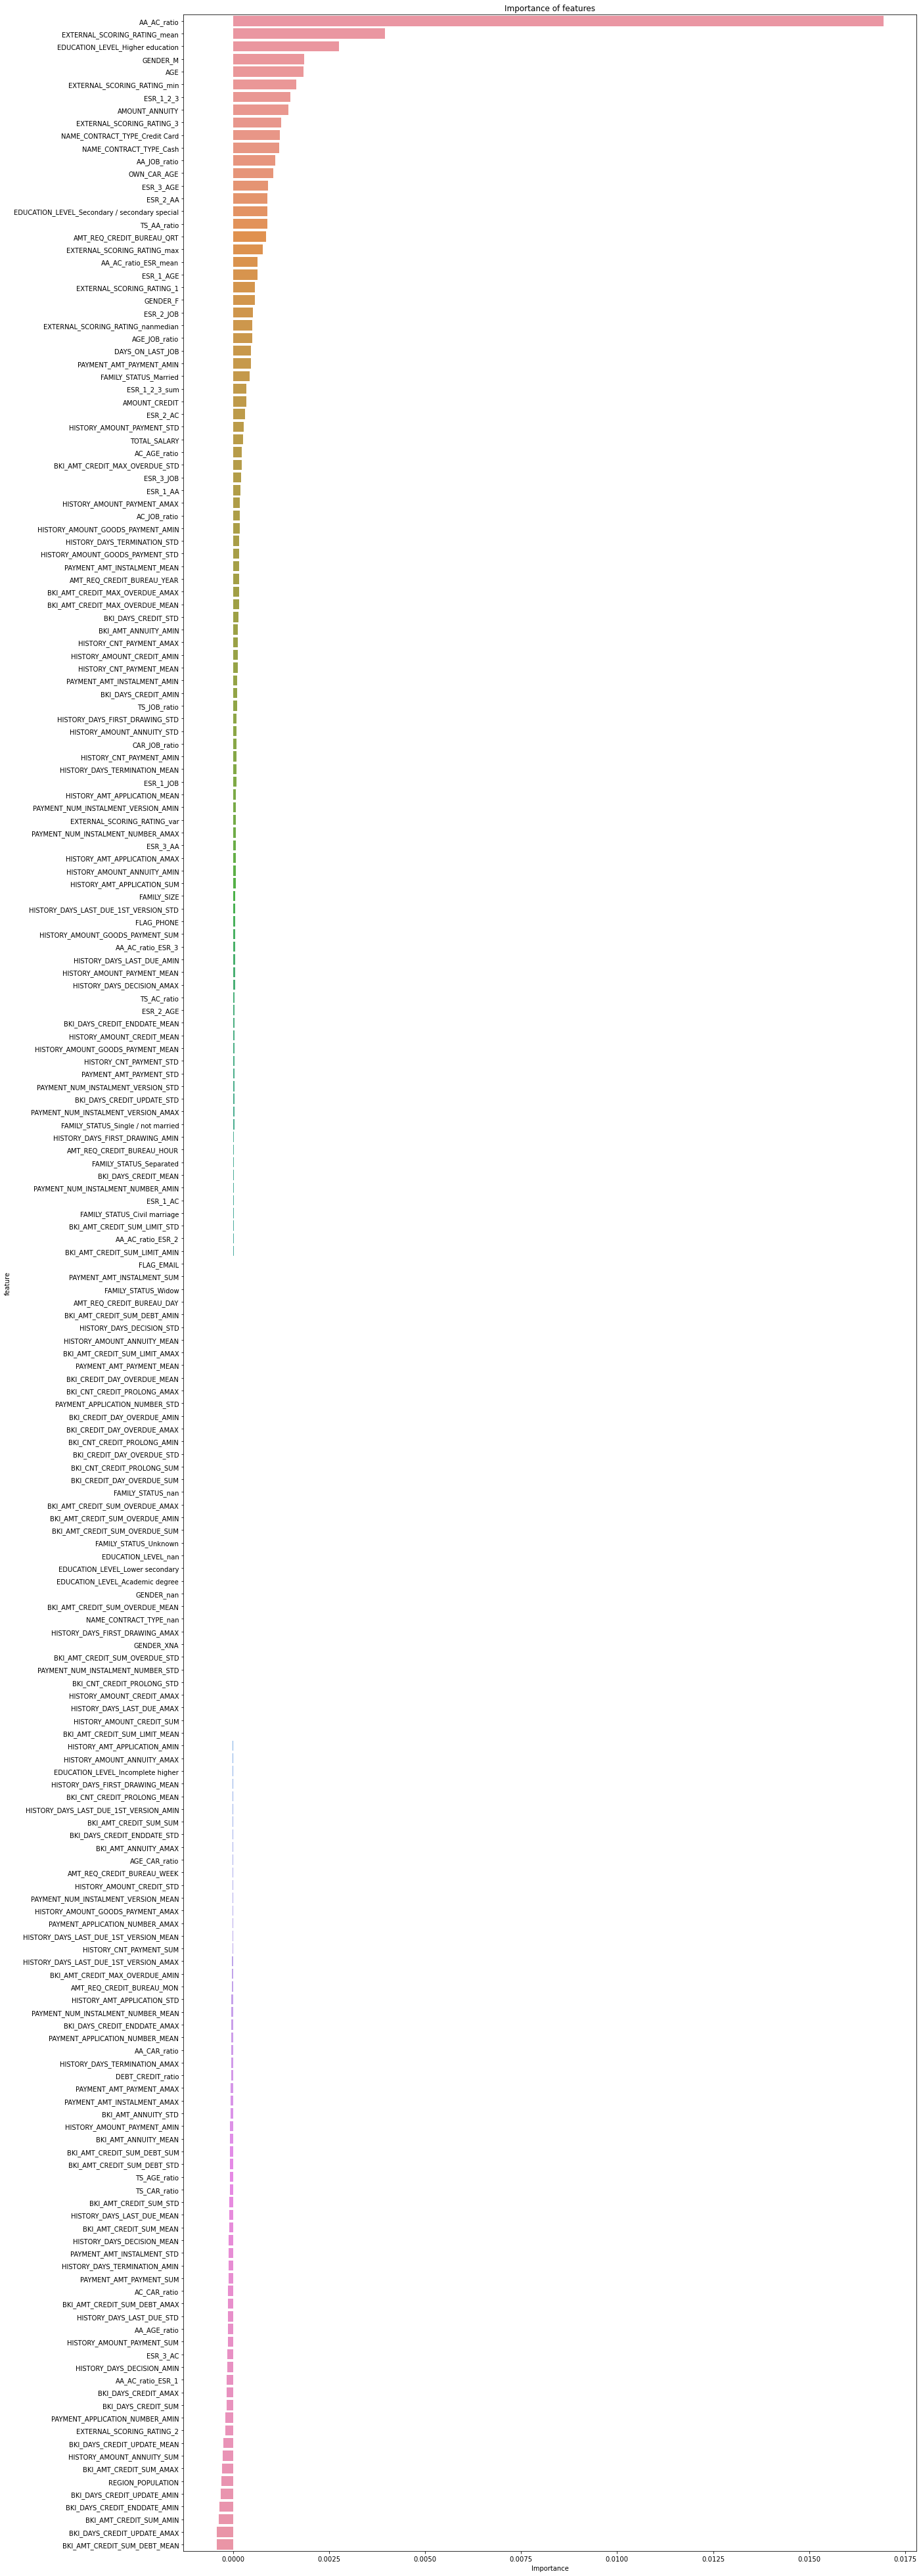

In [25]:
_ = show_feature_importances(importance_scores['features'].tolist(), importance_scores['importance-mean'].tolist(), get_top=100)

In [26]:
# top_feat_2 = importance_scores[importance_scores['importance-mean'] >= 0].features.tolist()

<font size="5">
После нескольких раундов выбора параметров получен список топовых параметров
</font>

In [27]:
# SAVE
# with open('model/top_feat.json', 'w') as file:
#     json.dump(top_feat, file)

In [28]:
# LOAD
with open('model/top_feat.json', 'r') as file:
    top_feat = json.load(file)

top_feat

['EXTERNAL_SCORING_RATING_mean',
 'AA_AC_ratio',
 'EXTERNAL_SCORING_RATING_nanmedian',
 'OWN_CAR_AGE',
 'EXTERNAL_SCORING_RATING_3',
 'EDUCATION_LEVEL_Higher education',
 'ESR_1_2_3',
 'AGE',
 'GENDER_M',
 'NAME_CONTRACT_TYPE_Cash',
 'AA_JOB_ratio',
 'TS_AA_ratio',
 'ESR_2_JOB',
 'ESR_2_AA',
 'AA_AGE_ratio',
 'ESR_1_AGE',
 'EXTERNAL_SCORING_RATING_1',
 'EXTERNAL_SCORING_RATING_min',
 'AMT_REQ_CREDIT_BUREAU_QRT',
 'EDUCATION_LEVEL_Secondary / secondary special',
 'PAYMENT_AMT_PAYMENT_AMIN',
 'AGE_JOB_ratio',
 'BKI_AMT_CREDIT_MAX_OVERDUE_AMAX',
 'NAME_CONTRACT_TYPE_Credit Card',
 'ESR_3_JOB',
 'HISTORY_AMOUNT_ANNUITY_AMIN',
 'FAMILY_STATUS_Married',
 'GENDER_F',
 'DAYS_ON_LAST_JOB',
 'AMT_REQ_CREDIT_BUREAU_YEAR',
 'HISTORY_AMOUNT_GOODS_PAYMENT_MEAN',
 'HISTORY_DAYS_TERMINATION_MEAN',
 'EXTERNAL_SCORING_RATING_max',
 'BKI_AMT_CREDIT_MAX_OVERDUE_STD',
 'FAMILY_SIZE']

In [29]:
# top_feat = ['EXTERNAL_SCORING_RATING_mean',
#  'AA_AC_ratio',
#  'EXTERNAL_SCORING_RATING_nanmedian',
#  'OWN_CAR_AGE',
#  'EXTERNAL_SCORING_RATING_3',
#  'EDUCATION_LEVEL_Higher education',
#  'ESR_1_2_3',
#  'AGE',
#  'GENDER_M',
#  'NAME_CONTRACT_TYPE_Cash',
#  'AA_JOB_ratio',
#  'TS_AA_ratio',
#  'ESR_2_JOB',
#  'ESR_2_AA',
#  'AA_AGE_ratio',
#  'ESR_1_AGE',
#  'EXTERNAL_SCORING_RATING_1',
#  'EXTERNAL_SCORING_RATING_min',
#  'AMT_REQ_CREDIT_BUREAU_QRT',
#  'EDUCATION_LEVEL_Secondary / secondary special',
#  'PAYMENT_AMT_PAYMENT_AMIN',
#  'AGE_JOB_ratio',
#  'BKI_AMT_CREDIT_MAX_OVERDUE_AMAX',
#  'NAME_CONTRACT_TYPE_Credit Card',
#  'ESR_3_JOB',
#  'HISTORY_AMOUNT_ANNUITY_AMIN',
#  'FAMILY_STATUS_Married',
#  'GENDER_F',
#  'DAYS_ON_LAST_JOB',
#  'AMT_REQ_CREDIT_BUREAU_YEAR',
#  'HISTORY_AMOUNT_GOODS_PAYMENT_MEAN',
#  'HISTORY_DAYS_TERMINATION_MEAN',
#  'EXTERNAL_SCORING_RATING_max',
#  'BKI_AMT_CREDIT_MAX_OVERDUE_STD',
#  'FAMILY_SIZE',]

In [30]:
x_train_for_cv = train_data[top_feat].reset_index(drop=True)
y_train_for_cv = train_data['TARGET'].reset_index(drop=True)

<h2>
<div class="alert-warning">
<font size="6" color='blue'>
Models
</font></div></h2>

In [31]:
params_for_stacking = {
    "eval_metric": "auc",
    "verbose": 10000,
}

### HyperParams tuning: GridSearchCV for LightGBM

In [32]:
params_for_GridSearchCV = {
    'learning_rate': [0.02, 0.05, 0.07, 0.1], 
    'num_leaves': [15, 21, 25, 31], 
    'reg_alpha': [1.0, 2.0, 5.0], 
    'reg_lambda': [5, 10, 25, 50, 100], 
    'min_child_samples': [250],
    'min_child_weight': [1],
    'colsample_bytree': [0.25],
}

In [33]:
model_lgb_opt = None
model_lgb_opt = lgb.LGBMClassifier(n_estimators=10000,
                                    max_depth=-1,
                                    subsample=0.95,
                                    boosting_type='gbdt',
                                    seed=5678941235)

In [34]:
cv_strategy = StratifiedKFold(n_splits=7, random_state=6482597, shuffle=True)

In [35]:
clf = GridSearchCV(estimator=model_lgb_opt, param_grid=params_for_GridSearchCV, scoring='roc_auc', n_jobs=-1, cv=cv_strategy)

In [36]:
# clf.fit(x_train_for_cv, y_train_for_cv)

In [37]:
# clf.best_params_

# {'colsample_bytree': 0.25,
#  'learning_rate': 0.02,
#  'min_child_samples': 250,
#  'min_child_weight': 1,
#  'num_leaves': 21,
#  'reg_alpha': 1.0,
#  'reg_lambda': 25}

### LightGBM

In [38]:
# SAVE
# with open('model/params_for_lgbm.json', 'w') as file:
#     json.dump(params_for_lgbm, file)

In [39]:
# LOAD
with open('model/params_for_lgbm.json', 'r') as file:
    params_for_lgbm = json.load(file)
    
params_for_lgbm

{'boosting_type': 'gbdt',
 'learning_rate': 0.02,
 'num_leaves': 21,
 'max_depth': -1,
 'reg_alpha': 1.0,
 'reg_lambda': 25.0,
 'min_child_samples': 250,
 'min_child_weight': 1,
 'colsample_bytree': 0.25,
 'subsample': 0.95}

In [40]:
# params_for_lgbm = {
#     'boosting_type': 'gbdt',
#     'learning_rate': 0.02, 
#     'num_leaves': 21, 
#     'max_depth': -1,
#     'reg_alpha': 1.0, 
#     'reg_lambda': 25.0, 
#     'min_child_samples': 250,
#     'min_child_weight': 1,
#     'colsample_bytree': 0.25,
#     'subsample': 0.95,
# }

In [41]:
model_lgb_3 = lgb.LGBMClassifier(n_estimators=10000,
                                 seed=5678941235,
                                 **params_for_lgbm)

In [42]:
cv_strategy = StratifiedKFold(n_splits=7, random_state=6482597, shuffle=True)

estimators_lgb, oof_score_lgb, fold_train_scores_lgb, fold_valid_scores_lgb, oof_predictions_lgb = make_cross_validation(
    x_train_for_cv, y_train_for_cv, model_lgb_3, params, metric=roc_auc_score, cv_strategy=cv_strategy
)

Training until validation scores don't improve for 100 rounds
[250]	valid_0's auc: 0.726862	valid_0's binary_logloss: 0.254011
[500]	valid_0's auc: 0.729677	valid_0's binary_logloss: 0.252847
Early stopping, best iteration is:
[598]	valid_0's auc: 0.73017	valid_0's binary_logloss: 0.252692
Fold: 1, train-observations = 94365, valid-observations = 15728
train-score = 0.7737, valid-score = 0.7302
Training until validation scores don't improve for 100 rounds
[250]	valid_0's auc: 0.727911	valid_0's binary_logloss: 0.252975
[500]	valid_0's auc: 0.731856	valid_0's binary_logloss: 0.251516
Early stopping, best iteration is:
[621]	valid_0's auc: 0.732176	valid_0's binary_logloss: 0.25141
Fold: 2, train-observations = 94365, valid-observations = 15728
train-score = 0.7743, valid-score = 0.7322
Training until validation scores don't improve for 100 rounds
[250]	valid_0's auc: 0.72328	valid_0's binary_logloss: 0.254488
[500]	valid_0's auc: 0.728612	valid_0's binary_logloss: 0.253034
Early stoppin

In [43]:
oof_score = roc_auc_score(y_train_for_cv, oof_predictions_lgb)
oof_score # 0.7317

0.73174233048096

In [44]:
n_estimators = 0
for n in range(len(estimators_lgb)):
    n_estimators += estimators_lgb[n].best_iteration_
n_estimators /= len(estimators_lgb)
n_estimators = int(n_estimators)
n_estimators

650

In [45]:
model_lgb_3_stack = lgb.LGBMClassifier(n_estimators=n_estimators,
                                         seed=5678941235,
                                         **params_for_lgbm)

cv_strategy = StratifiedKFold(n_splits=7, random_state=6482597, shuffle=True)

estimators_lgb_stack, oof_score_lgb_stack, fold_train_scores_lgb_stack, fold_valid_scores_lgb_stack, oof_predictions_lgb_stack = make_cross_validation(
    x_train_for_cv, y_train_for_cv, model_lgb_3_stack, params_for_stacking, metric=roc_auc_score, cv_strategy=cv_strategy
)

Fold: 1, train-observations = 94365, valid-observations = 15728
train-score = 0.7764, valid-score = 0.73
Fold: 2, train-observations = 94365, valid-observations = 15728
train-score = 0.7757, valid-score = 0.732
Fold: 3, train-observations = 94365, valid-observations = 15728
train-score = 0.7763, valid-score = 0.7287
Fold: 4, train-observations = 94365, valid-observations = 15728
train-score = 0.7747, valid-score = 0.7334
Fold: 5, train-observations = 94366, valid-observations = 15727
train-score = 0.776, valid-score = 0.7324
Fold: 6, train-observations = 94366, valid-observations = 15727
train-score = 0.776, valid-score = 0.7312
Fold: 7, train-observations = 94366, valid-observations = 15727
train-score = 0.7756, valid-score = 0.7343
CV-results train: 0.7758 +/- 0.001
CV-results valid: 0.7317 +/- 0.002
OOF-score = 0.7316


### XGBoost

In [46]:
# SAVE
# with open('model/params_for_xgb.json', 'w') as file:
#     json.dump(params_for_xgb, file)

In [47]:
# LOAD
with open('model/params_for_xgb.json', 'r') as file:
    params_for_xgb = json.load(file)
    
params_for_xgb

{'learning_rate': 0.07,
 'max_depth': 4,
 'reg_alpha': 1.0,
 'reg_lambda': 25.0,
 'gamma': 5.0,
 'min_child_weight': 1,
 'colsample_bytree': 0.25,
 'subsample': 0.95}

In [48]:
# params_for_xgb = {
#     'learning_rate': 0.07, 
#     'max_depth': 4,
#     'reg_alpha': 1.0, 
#     'reg_lambda': 25.0, 
#     'gamma': 5.0,
#     'min_child_weight': 1,
#     'colsample_bytree': 0.25,
#     'subsample': 0.95,
# }

In [49]:
model_xgb_3 = xgb.XGBClassifier(n_estimators=10000,
                                 seed=5678941235,
                                 **params_for_xgb)

In [50]:
cv_strategy = StratifiedKFold(n_splits=7, random_state=6482597, shuffle=True)

estimators_xgb, oof_score_xgb, fold_train_scores_xgb, fold_valid_scores_xgb, oof_predictions_xgb = make_cross_validation(
    x_train_for_cv, y_train_for_cv, model_xgb_3, params, metric=roc_auc_score, cv_strategy=cv_strategy
)

[0]	validation_0-auc:0.60974	validation_1-auc:0.60198
[250]	validation_0-auc:0.75312	validation_1-auc:0.72952
[500]	validation_0-auc:0.76588	validation_1-auc:0.73280
[736]	validation_0-auc:0.77125	validation_1-auc:0.73346
Fold: 1, train-observations = 94365, valid-observations = 15728
train-score = 0.7692, valid-score = 0.7337
[0]	validation_0-auc:0.60529	validation_1-auc:0.61340
[250]	validation_0-auc:0.75315	validation_1-auc:0.73051
[500]	validation_0-auc:0.76404	validation_1-auc:0.73357
[714]	validation_0-auc:0.76929	validation_1-auc:0.73403
Fold: 2, train-observations = 94365, valid-observations = 15728
train-score = 0.7671, valid-score = 0.7345
[0]	validation_0-auc:0.60612	validation_1-auc:0.60189
[250]	validation_0-auc:0.75433	validation_1-auc:0.72835
[388]	validation_0-auc:0.76147	validation_1-auc:0.72820
Fold: 3, train-observations = 94365, valid-observations = 15728
train-score = 0.7567, valid-score = 0.7287
[0]	validation_0-auc:0.59628	validation_1-auc:0.59855
[250]	validatio

In [51]:
oof_score = roc_auc_score(y_train_for_cv, oof_predictions_xgb)
oof_score # 0.7334

0.7334229240737784

In [52]:
n_estimators = 0
for n in range(len(estimators_xgb)):
    n_estimators += estimators_xgb[n].best_iteration
n_estimators /= len(estimators_xgb)
n_estimators = int(n_estimators)
n_estimators

598

In [53]:
model_xgb_3_stack = xgb.XGBClassifier(n_estimators=n_estimators, 
                                     seed=5678941235,
                                     **params_for_xgb)

cv_strategy = StratifiedKFold(n_splits=7, random_state=6482597, shuffle=True)

estimators_xgb_stack, oof_score_xgb_stack, fold_train_scores_xgb_stack, fold_valid_scores_xgb_stack, oof_predictions_xgb_stack = make_cross_validation(
    x_train_for_cv, y_train_for_cv, model_xgb_3_stack, params_for_stacking, metric=roc_auc_score, cv_strategy=cv_strategy
)

[0]	validation_0-auc:0.60974	validation_1-auc:0.60198
[597]	validation_0-auc:0.76841	validation_1-auc:0.73326
Fold: 1, train-observations = 94365, valid-observations = 15728
train-score = 0.7684, valid-score = 0.7333
[0]	validation_0-auc:0.60529	validation_1-auc:0.61340
[597]	validation_0-auc:0.76666	validation_1-auc:0.73420
Fold: 2, train-observations = 94365, valid-observations = 15728
train-score = 0.7667, valid-score = 0.7342
[0]	validation_0-auc:0.60612	validation_1-auc:0.60189
[597]	validation_0-auc:0.76774	validation_1-auc:0.72798
Fold: 3, train-observations = 94365, valid-observations = 15728
train-score = 0.7677, valid-score = 0.728
[0]	validation_0-auc:0.59628	validation_1-auc:0.59855
[597]	validation_0-auc:0.76598	validation_1-auc:0.73314
Fold: 4, train-observations = 94365, valid-observations = 15728
train-score = 0.766, valid-score = 0.7331
[0]	validation_0-auc:0.61449	validation_1-auc:0.60464
[597]	validation_0-auc:0.76595	validation_1-auc:0.73493
Fold: 5, train-observati

### CatBoost

In [54]:
# SAVE
# with open('model/params_for_cb.json', 'w') as file:
#     json.dump(params_for_cb, file)

In [55]:
# LOAD
with open('model/params_for_cb.json', 'r') as file:
    params_for_cb = json.load(file)
    
params_for_cb

{'learning_rate': 0.05,
 'max_depth': 4,
 'reg_lambda': 25.0,
 'min_data_in_leaf': 1,
 'colsample_bylevel': 0.25,
 'subsample': 0.95,
 'loss_function': 'Logloss',
 'eval_metric': 'AUC',
 'verbose': 0,
 'early_stopping_rounds': 100}

In [56]:
# params_for_cb = {
#     'learning_rate': 0.05, 
#     'max_depth': 4,
#     'reg_lambda': 25.0, 
#     'min_data_in_leaf': 1,
#     'colsample_bylevel': 0.25,
#     'subsample': 0.95,
#     'loss_function': 'Logloss',
#     'eval_metric': 'AUC',
#     'verbose': 0,
#     'early_stopping_rounds': 100,
# }

In [57]:
model_cb_1 = cb.CatBoostClassifier(n_estimators=10000, 
                                    random_seed=5678941235,
                                    **params_for_cb)

In [58]:
cv_strategy = StratifiedKFold(n_splits=7, random_state=6482597, shuffle=True)

estimators_cb, oof_score_cb, fold_train_scores_cb, fold_valid_scores_cb, oof_predictions_cb = make_cross_validation(
    x_train_for_cv, y_train_for_cv, model_cb_1, {}, metric=roc_auc_score, cv_strategy=cv_strategy
)

Fold: 1, train-observations = 94365, valid-observations = 15728
train-score = 0.7603, valid-score = 0.7293
Fold: 2, train-observations = 94365, valid-observations = 15728
train-score = 0.7646, valid-score = 0.7316
Fold: 3, train-observations = 94365, valid-observations = 15728
train-score = 0.7527, valid-score = 0.7287
Fold: 4, train-observations = 94365, valid-observations = 15728
train-score = 0.7705, valid-score = 0.7341
Fold: 5, train-observations = 94366, valid-observations = 15727
train-score = 0.7722, valid-score = 0.7328
Fold: 6, train-observations = 94366, valid-observations = 15727
train-score = 0.7698, valid-score = 0.7274
Fold: 7, train-observations = 94366, valid-observations = 15727
train-score = 0.7494, valid-score = 0.7311
CV-results train: 0.7628 +/- 0.008
CV-results valid: 0.7307 +/- 0.002
OOF-score = 0.7305


In [59]:
oof_score = roc_auc_score(y_train_for_cv, oof_predictions_cb)
oof_score # 0.7305

0.7305322881442367

In [60]:
n_estimators = 0
for n in range(len(estimators_cb)):
    n_estimators += estimators_cb[n].best_iteration_
n_estimators /= len(estimators_cb)
n_estimators = int(n_estimators)
n_estimators

949

In [61]:
model_cb_1_stack = cb.CatBoostClassifier(n_estimators=n_estimators, 
                                            random_seed=5678941235,
                                            **params_for_cb)

cv_strategy = StratifiedKFold(n_splits=7, random_state=6482597, shuffle=True)

estimators_cb_stack, oof_score_cb_stack, fold_train_scores_cb_stack, fold_valid_scores_cb_stack, oof_predictions_cb_stack = make_cross_validation(
    x_train_for_cv, y_train_for_cv, model_cb_1_stack, {}, metric=roc_auc_score, cv_strategy=cv_strategy
)

Fold: 1, train-observations = 94365, valid-observations = 15728
train-score = 0.7603, valid-score = 0.7293
Fold: 2, train-observations = 94365, valid-observations = 15728
train-score = 0.7646, valid-score = 0.7316
Fold: 3, train-observations = 94365, valid-observations = 15728
train-score = 0.7527, valid-score = 0.7287
Fold: 4, train-observations = 94365, valid-observations = 15728
train-score = 0.763, valid-score = 0.7328
Fold: 5, train-observations = 94366, valid-observations = 15727
train-score = 0.7623, valid-score = 0.7322
Fold: 6, train-observations = 94366, valid-observations = 15727
train-score = 0.7614, valid-score = 0.7267
Fold: 7, train-observations = 94366, valid-observations = 15727
train-score = 0.7494, valid-score = 0.7311
CV-results train: 0.7591 +/- 0.005
CV-results valid: 0.7304 +/- 0.002
OOF-score = 0.7302


<h3>
<font size="5" color='purple'>
Stacking
</font></h3>

In [62]:
train_stack = []
for estimator in estimators_lgb_stack:
    pred = estimator.predict_proba(x_train_for_cv[top_feat])[:,1]
    train_stack.append(pred) 
for estimator in estimators_xgb_stack:
    pred = estimator.predict_proba(x_train_for_cv[top_feat])[:,1]
    train_stack.append(pred)
for estimator in estimators_cb_stack:
    pred = estimator.predict_proba(x_train_for_cv[top_feat])[:,1]
    train_stack.append(pred)

In [63]:
stacking_model = xgb.XGBClassifier(n_estimators=150, learning_rate=0.05, max_depth=2,
                                   seed=526487)

cv_strategy = StratifiedKFold(n_splits=7, random_state=6482597, shuffle=True)

estimators_stacking, oof_score_stacking, fold_train_stacking, fold_valid_scores_stacking, oof_predictions_stacking = make_cross_validation(
    pd.DataFrame(np.array(train_stack).T), y_train_for_cv, stacking_model, params, metric=roc_auc_score, cv_strategy=cv_strategy
)

[0]	validation_0-auc:0.73641	validation_1-auc:0.69329
[149]	validation_0-auc:0.79016	validation_1-auc:0.72157
Fold: 1, train-observations = 94365, valid-observations = 15728
train-score = 0.7779, valid-score = 0.73
[0]	validation_0-auc:0.74448	validation_1-auc:0.69979
[149]	validation_0-auc:0.79174	validation_1-auc:0.72689
Fold: 2, train-observations = 94365, valid-observations = 15728
train-score = 0.7767, valid-score = 0.7333
[0]	validation_0-auc:0.74268	validation_1-auc:0.70192
[149]	validation_0-auc:0.79066	validation_1-auc:0.72347
Fold: 3, train-observations = 94365, valid-observations = 15728
train-score = 0.7773, valid-score = 0.7293
[0]	validation_0-auc:0.74574	validation_1-auc:0.70554
[149]	validation_0-auc:0.78843	validation_1-auc:0.72797
Fold: 4, train-observations = 94365, valid-observations = 15728
train-score = 0.7773, valid-score = 0.735
[0]	validation_0-auc:0.73696	validation_1-auc:0.69142
[149]	validation_0-auc:0.79058	validation_1-auc:0.72518
Fold: 5, train-observatio

<h2>
<div class="alert-warning">
<font size="6" color='blue'>
Predictions for LB_dataset
</font></div></h2>

In [64]:
lb_dataset = client_profile_prep(test_data, client_profile_data)
lb_dataset = payments_data_prep(lb_dataset, payments_data)
lb_dataset = bki_data_prep(lb_dataset, bki_data)
lb_dataset = applications_history_data_prep(lb_dataset, applications_history_data)
lb_dataset = data_preparation(lb_dataset, cats_to_dummies=['NAME_CONTRACT_TYPE', 'GENDER', 'EDUCATION_LEVEL', 'FAMILY_STATUS'])
lb_dataset.shape

(165141, 201)

In [65]:
lb_dataset.head(2)

,APPLICATION_NUMBER,TOTAL_SALARY,AMOUNT_CREDIT,AMOUNT_ANNUITY,REGION_POPULATION,AGE,DAYS_ON_LAST_JOB,OWN_CAR_AGE,FLAG_PHONE,FLAG_EMAIL,FAMILY_SIZE,EXTERNAL_SCORING_RATING_1,EXTERNAL_SCORING_RATING_2,EXTERNAL_SCORING_RATING_3,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,AA_AC_ratio,TS_AA_ratio,TS_AC_ratio,AGE_JOB_ratio,AGE_CAR_ratio,CAR_JOB_ratio,AA_AGE_ratio,TS_AGE_ratio,AC_AGE_ratio,AA_JOB_ratio,TS_JOB_ratio,AC_JOB_ratio,AA_CAR_ratio,TS_CAR_ratio,AC_CAR_ratio,EXTERNAL_SCORING_RATING_min,EXTERNAL_SCORING_RATING_max,EXTERNAL_SCORING_RATING_mean,EXTERNAL_SCORING_RATING_nanmedian,EXTERNAL_SCORING_RATING_var,AA_AC_ratio_ESR_1,AA_AC_ratio_ESR_2,AA_AC_ratio_ESR_3,AA_AC_ratio_ESR_mean,ESR_1_AA,ESR_2_AA,ESR_3_AA,ESR_1_AC,ESR_2_AC,ESR_3_AC,ESR_1_AGE,ESR_2_AGE,ESR_3_AGE,ESR_1_JOB,ESR_2_JOB,ESR_3_JOB,ESR_1_2_3,ESR_1_2_3_sum,PAYMENT_NUM_INSTALMENT_VERSION_AMIN,PAYMENT_NUM_INSTALMENT_VERSION_AMAX,PAYMENT_NUM_INSTALMENT_VERSION_MEAN,PAYMENT_NUM_INSTALMENT_VERSION_STD,PAYMENT_NUM_INSTALMENT_NUMBER_AMIN,PAYMENT_NUM_INSTALMENT_NUMBER_AMAX,PAYMENT_NUM_INSTALMENT_NUMBER_MEAN,PAYMENT_NUM_INSTALMENT_NUMBER_STD,PAYMENT_AMT_INSTALMENT_AMIN,PAYMENT_AMT_INSTALMENT_AMAX,PAYMENT_AMT_INSTALMENT_MEAN,PAYMENT_AMT_INSTALMENT_SUM,PAYMENT_AMT_INSTALMENT_STD,PAYMENT_AMT_PAYMENT_AMIN,PAYMENT_AMT_PAYMENT_AMAX,PAYMENT_AMT_PAYMENT_MEAN,PAYMENT_AMT_PAYMENT_SUM,PAYMENT_AMT_PAYMENT_STD,PAYMENT_APPLICATION_NUMBER_AMIN,PAYMENT_APPLICATION_NUMBER_AMAX,PAYMENT_APPLICATION_NUMBER_MEAN,PAYMENT_APPLICATION_NUMBER_STD,BKI_DAYS_CREDIT_AMIN,BKI_DAYS_CREDIT_AMAX,BKI_DAYS_CREDIT_MEAN,BKI_DAYS_CREDIT_SUM,BKI_DAYS_CREDIT_STD,BKI_CREDIT_DAY_OVERDUE_AMIN,BKI_CREDIT_DAY_OVERDUE_AMAX,BKI_CREDIT_DAY_OVERDUE_MEAN,BKI_CREDIT_DAY_OVERDUE_SUM,BKI_CREDIT_DAY_OVERDUE_STD,BKI_DAYS_CREDIT_ENDDATE_AMIN,BKI_DAYS_CREDIT_ENDDATE_AMAX,BKI_DAYS_CREDIT_ENDDATE_MEAN,BKI_DAYS_CREDIT_ENDDATE_STD,BKI_AMT_CREDIT_MAX_OVERDUE_AMIN,BKI_AMT_CREDIT_MAX_OVERDUE_AMAX,BKI_AMT_CREDIT_MAX_OVERDUE_MEAN,BKI_AMT_CREDIT_MAX_OVERDUE_STD,BKI_CNT_CREDIT_PROLONG_AMIN,BKI_CNT_CREDIT_PROLONG_AMAX,BKI_CNT_CREDIT_PROLONG_MEAN,BKI_CNT_CREDIT_PROLONG_SUM,BKI_CNT_CREDIT_PROLONG_STD,BKI_AMT_CREDIT_SUM_AMIN,BKI_AMT_CREDIT_SUM_AMAX,BKI_AMT_CREDIT_SUM_MEAN,BKI_AMT_CREDIT_SUM_SUM,BKI_AMT_CREDIT_SUM_STD,BKI_AMT_CREDIT_SUM_DEBT_AMIN,BKI_AMT_CREDIT_SUM_DEBT_AMAX,BKI_AMT_CREDIT_SUM_DEBT_MEAN,BKI_AMT_CREDIT_SUM_DEBT_SUM,BKI_AMT_CREDIT_SUM_DEBT_STD,BKI_AMT_CREDIT_SUM_LIMIT_AMIN,BKI_AMT_CREDIT_SUM_LIMIT_AMAX,BKI_AMT_CREDIT_SUM_LIMIT_MEAN,BKI_AMT_CREDIT_SUM_LIMIT_STD,BKI_AMT_CREDIT_SUM_OVERDUE_AMIN,BKI_AMT_CREDIT_SUM_OVERDUE_AMAX,BKI_AMT_CREDIT_SUM_OVERDUE_MEAN,BKI_AMT_CREDIT_SUM_OVERDUE_SUM,BKI_AMT_CREDIT_SUM_OVERDUE_STD,BKI_DAYS_CREDIT_UPDATE_AMIN,BKI_DAYS_CREDIT_UPDATE_AMAX,BKI_DAYS_CREDIT_UPDATE_MEAN,BKI_DAYS_CREDIT_UPDATE_STD,BKI_AMT_ANNUITY_AMIN,BKI_AMT_ANNUITY_AMAX,BKI_AMT_ANNUITY_MEAN,BKI_AMT_ANNUITY_STD,DEBT_CREDIT_ratio,HISTORY_AMOUNT_ANNUITY_AMIN,HISTORY_AMOUNT_ANNUITY_AMAX,HISTORY_AMOUNT_ANNUITY_MEAN,HISTORY_AMOUNT_ANNUITY_SUM,HISTORY_AMOUNT_ANNUITY_STD,HISTORY_AMT_APPLICATION_AMIN,HISTORY_AMT_APPLICATION_AMAX,HISTORY_AMT_APPLICATION_MEAN,HISTORY_AMT_APPLICATION_SUM,HISTORY_AMT_APPLICATION_STD,HISTORY_AMOUNT_CREDIT_AMIN,HISTORY_AMOUNT_CREDIT_AMAX,HISTORY_AMOUNT_CREDIT_MEAN,HISTORY_AMOUNT_CREDIT_SUM,HISTORY_AMOUNT_CREDIT_STD,HISTORY_AMOUNT_PAYMENT_AMIN,HISTORY_AMOUNT_PAYMENT_AMAX,HISTORY_AMOUNT_PAYMENT_MEAN,HISTORY_AMOUNT_PAYMENT_SUM,HISTORY_AMOUNT_PAYMENT_STD,HISTORY_AMOUNT_GOODS_PAYMENT_AMIN,HISTORY_AMOUNT_GOODS_PAYMENT_AMAX,HISTORY_AMOUNT_GOODS_PAYMENT_MEAN,HISTORY_AMOUNT_GOODS_PAYMENT_SUM,HISTORY_AMOUNT_GOODS_PAYMENT_STD,HISTORY_DAYS_DECISION_AMIN,HISTORY_DAYS_DECISION_AMAX,HISTORY_DAYS_DECISION_MEAN,HISTORY_DAYS_DECISION_STD,HISTORY_CNT_PAYMENT_AMIN,HISTORY_CNT_PAYMENT_AMAX,HISTORY_CNT_PAYMENT_MEAN,HISTORY_CNT_PAYMENT_SUM,HISTORY_CNT_PAYMENT_STD,HISTORY_DAYS_FIRST_DRAWING_AMIN,HISTORY_DAYS_FIRST_DRAWING_AMAX,HISTOR

In [66]:
test_score = []
for estimator in estimators_lgb_stack:
    pred = estimator.predict_proba(lb_dataset[top_feat])[:,1]
    test_score.append(pred)
for estimator in estimators_xgb_stack:
    pred = estimator.predict_proba(lb_dataset[top_feat])[:,1]
    test_score.append(pred)
for estimator in estimators_cb_stack:
    pred = estimator.predict_proba(lb_dataset[top_feat])[:,1]
    test_score.append(pred)

In [67]:
scores_corr = pd.DataFrame({
    "lgbm_1": test_score[0],
    "lgbm_2": test_score[1],
    "lgbm_3": test_score[2],
    "lgbm_4": test_score[3],
    "lgbm_5": test_score[4],
    "lgbm_6": test_score[5],
    "lgbm_7": test_score[6],
    "xgb_1": test_score[7],
    "xgb_2": test_score[8],
    "xgb_3": test_score[9],
    "xgb_4": test_score[10],
    "xgb_5": test_score[11],
    "xgb_6": test_score[12],
    "xgb_7": test_score[13],
    "cb_1": test_score[14],
    "cb_2": test_score[15],
    "cb_3": test_score[16],
    "cb_4": test_score[17],
    "cb_5": test_score[18],
    "cb_6": test_score[19],
    "cb_7": test_score[20],
})

corr = scores_corr.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

<AxesSubplot:>

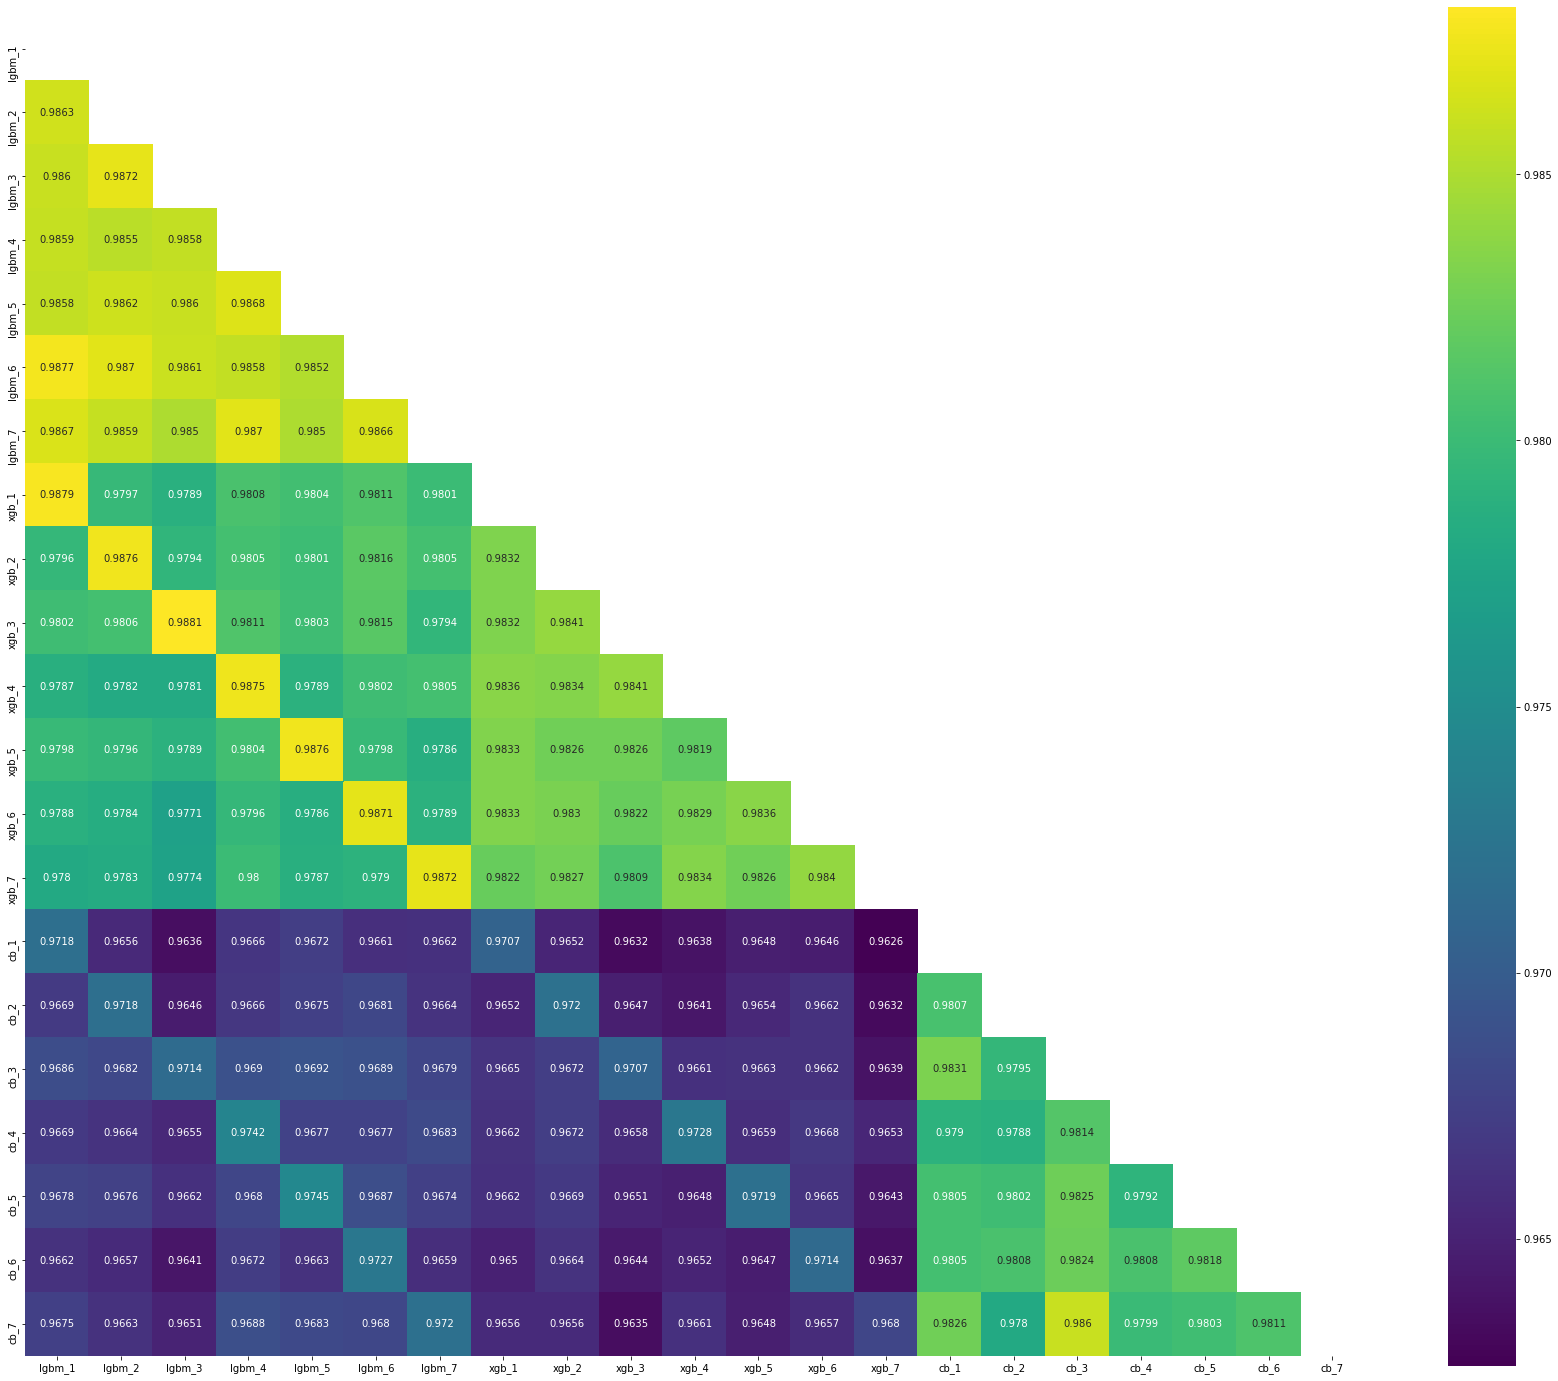

In [68]:
fig, axes = plt.subplots(1, 1, figsize=(30, 25))
sns.heatmap(corr, mask=mask, annot=True, fmt=".4g", square=True, cmap="viridis", ax=axes)

<h3>
<font size="5" color='green'>
Predict and save results for STACKING
</font></h3>

In [69]:
result_score = []
for estimator in estimators_stacking:
    pred = estimator.predict_proba(pd.DataFrame(np.array(test_score).T))[:,1]
    result_score.append(pred)

In [70]:
# result_score = gmean(result_score, axis=0)
result_score = np.mean(result_score, axis=0)

In [71]:
Shenk_ES_submit_52 = test_data[['APPLICATION_NUMBER']]
Shenk_ES_submit_52['TARGET'] = result_score
Shenk_ES_submit_52

,APPLICATION_NUMBER,TARGET
0,123724268,0.071149
1,123456549,0.295858
2,123428178,0.150802
3,123619984,0.088832
4,123671104,0.028553
...,...,...
165136,123487967,0.101701
165137,123536402,0.058772
165138,123718238,0.091387
165139,123631557,0.028315


In [72]:
Shenk_ES_submit_52.to_csv('Shenk_ES_submit_52.csv', index=False) # LB score: 0.73346

<h3>
<font size="5" color='green'>
Predict and save results for XGBoost
</font></h3>

In [73]:
test_score = []
 
for estimator in estimators_xgb_stack:
    pred = estimator.predict_proba(lb_dataset[top_feat])[:,1]
    test_score.append(pred)
    
result_score = np.mean(test_score, axis=0)

In [74]:
Shenk_ES_submit_51 = test_data[['APPLICATION_NUMBER']]
Shenk_ES_submit_51['TARGET'] = result_score
Shenk_ES_submit_51

,APPLICATION_NUMBER,TARGET
0,123724268,0.060534
1,123456549,0.272615
2,123428178,0.143191
3,123619984,0.078260
4,123671104,0.014453
...,...,...
165136,123487967,0.083581
165137,123536402,0.043993
165138,123718238,0.078956
165139,123631557,0.013158


In [75]:
Shenk_ES_submit_51.to_csv('Shenk_ES_submit_51.csv', index=False) # LB score: 0.73370